## 1. Importing Libraries

In [2]:
import pandas as pd          ### For handling dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizerFast       ### DistilBERT Tokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW    ### Optimizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.plotting.backend = "plotly"

## 2. Preparing dataset

In [3]:
# Load the dataset
df = pd.read_csv('/content/sample_data/Tweets.csv')

df = df[df['airline_sentiment']=='negative'][['text','negativereason']]
df.reset_index(drop=True,inplace=True)

In [4]:
df.head()

,text,negativereason
0,@VirginAmerica it's really aggressive to blast...,Bad Flight
1,@VirginAmerica and it's a really big bad thing...,Can't Tell
2,@VirginAmerica seriously would pay $30 a fligh...,Can't Tell
3,@VirginAmerica SFO-PDX schedule is still MIA.,Late Flight
4,@VirginAmerica I flew from NYC to SFO last we...,Bad Flight


In [5]:
# Display statistics about the dataset
print("\nDataset Statistics:")
print(df['negativereason'].value_counts())


Dataset Statistics:
negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Flight Booking Problems         924
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Attendant Complaints     481
longlines                       178
Baggage Issue                   150
Damaged Luggage                  74
Name: count, dtype: int64


In [6]:
df = df[(df['negativereason'] != "Can't Tell")]
df.loc[df['negativereason'] == 'Baggage Issue', 'negativereason'] = 'Damaged Luggage'

<ipython-input-6-8a7fab00160a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['negativereason'] == 'Baggage Issue', 'negativereason'] = 'Damaged Luggage'


In [7]:
df.isnull().sum()

text              23
negativereason    23
dtype: int64

In [8]:
df['negativereason'].value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Flight Booking Problems         924
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Attendant Complaints     481
Damaged Luggage                 224
longlines                       178
Name: count, dtype: int64

In [9]:
df['negativereason'] = df['negativereason'].map({'Customer Service Issue': 0 , 'Late Flight' : 1, 'Cancelled Flight':4, 'Lost Luggage':2, 'Bad Flight': 4, 'Flight Booking Problems': 3, 'Flight Attendant Complaints':3, 'longlines':0,'Damaged Luggage':2})
df.head()

,text,negativereason
0,@VirginAmerica it's really aggressive to blast...,4.0
3,@VirginAmerica SFO-PDX schedule is still MIA.,1.0
4,@VirginAmerica I flew from NYC to SFO last we...,4.0
6,@VirginAmerica you guys messed up my seating.....,0.0
7,@VirginAmerica status match program. I applie...,0.0


## 3. EDA

In [10]:
# The distribution of sentiments
df.groupby('negativereason').count().plot(kind='bar')

In [11]:
# Calculate tweet lengths
df = df[df['text'].notnull()]
tweet_len = pd.Series([len(tweet.split()) for tweet in df['text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

In [12]:
import plotly.express as px
fig = px.pie(df, names='negativereason', title ='Pie chart of different sentiments of tweets')
fig.show()

## 4. Creating Dataloader

- To load data in batches while fine tuning so that to avoid memory bottleneck.

In [13]:
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataset = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        review_text = self.dataset.iloc[idx, 0]  # Assuming reviewText is the first column
        sentiment = self.dataset.iloc[idx, 1]  # Assuming sentiment is the second column

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,  # Add [CLS] token at the start for classification
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'review_text': review_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(), # this is NOT self-attention!
          'labels': torch.tensor(sentiment, dtype=torch.long)
        }

In [14]:
### Loading tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
review_dataset = ReviewDataset(df , tokenizer, 40)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
review_dataset[0]

{'review_text': '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 'input_ids': tensor([  101,  1030,  6261, 14074, 14735,  2009,  1005,  1055,  2428,  9376,
          2000,  8479, 27885,  3630, 25171,  1000,  4024,  1000,  1999,  2115,
          6368,  1005,  5344,  1004, 23713,  1025,  2027,  2031,  2210, 28667,
         22957,  2063,   102,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(4)}

In [16]:
tokenizer.decode(review_dataset[0]['input_ids'])

'[CLS] @ virginamerica it\'s really aggressive to blast obnoxious " entertainment " in your guests\'faces & amp ; they have little recourse [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [17]:
# Split dataset into training and validation

train_size = int(0.8 * len(df))
val_size = len(df) - train_size
train_dataset, test_dataset = random_split(review_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [18]:
# Show number of batches
len(train_loader), len(test_loader)

(427, 107)

## 5. Model Building

In [19]:
### Model Architecture Building

class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self, num_labels=5):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(768, 768)  # DistilBERT's hidden size is 768
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # we take the representation of the [CLS] token (first token)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output) # regularization
        logits = self.classifier(pooled_output)
        return logits


In [20]:
### Loading model object
model = CustomDistilBertForSequenceClassification()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [21]:
# Inspect DistilBERT
print(model.distilbert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

## 6. Fine tuning DistilBERT

In [22]:
accuracy_list = []

In [23]:
def pred_model():
    ### Making predictions on test set
    model.eval()
    total_correct = 0
    total = 0
    y_pred = []
    y_test = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        y_test.extend(labels.cpu().numpy())
        with torch.inference_mode():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        total_correct += (predictions == labels).sum().item()
        total += predictions.size(0)

    avg_acc = total_correct / total
    print(f'Test Accuracy: {avg_acc:.4f}')
    accuracy_list.append(avg_acc)

In [24]:
### Training loop on training set
epoch_list = []
loss_list = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 40
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(epochs):
    epoch_list.append(epoch + 1)  # Epochs start from 1
    epoch_loss = 0.0  # Accumulator for loss in current epoch
    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # if (i + 1) % 100 == 0:
        #     print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")
    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    # Print epoch and average loss
    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}")
    pred_model()

Epoch 1, Average Loss: 0.8908
Test Accuracy: 0.7229
Epoch 2, Average Loss: 0.5351
Test Accuracy: 0.6954


KeyboardInterrupt: 

In [29]:
print(accuracy_list)
len(accuracy_list)
# accuracy_list.remove(accuracy_list[0])

[0.7006444053895724, 0.7006444053895724, 0.6971294669009959, 0.6983011130638547, 0.6977152899824253, 0.6983011130638547, 0.6977152899824253, 0.6994727592267135, 0.6977152899824253, 0.6432337434094904, 0.677211482132396, 0.687170474516696, 0.690099589923843, 0.6859988283538372, 0.6918570591681312, 0.6924428822495606, 0.6924428822495606, 0.6918570591681312, 0.6924428822495606, 0.6924428822495606, 0.6912712360867018, 0.6918570591681312, 0.6895137668424136, 0.69302870533099, 0.6760398359695372, 0.6731107205623902, 0.690099589923843, 0.6883421206795548, 0.687170474516696, 0.6842413591095489, 0.6859988283538372, 0.6783831282952548, 0.680140597539543, 0.6813122437024018, 0.6813122437024018, 0.6824838898652607, 0.68306971294669, 0.68306971294669, 0.68306971294669, 0.6836555360281195]


40

Text(0, 0.5, 'loss')

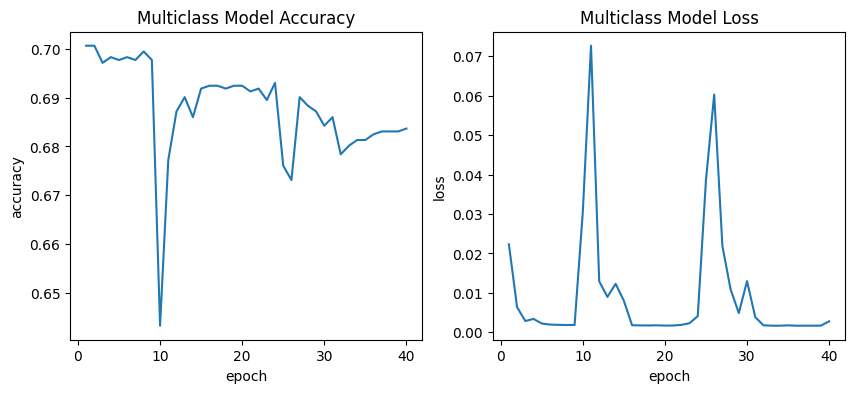

In [30]:
'''Function to plot history for accuracy and loss'''

fig, ax = plt.subplots(1, 2, figsize=(10,4))
# first plot
ax[0].plot(epoch_list, accuracy_list)
# ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Multiclass Model Accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
# ax[0].legend(['train', 'validation'], loc='best')
# second plot
ax[1].plot(epoch_list, loss_list)
# ax[1].plot(history.history['val_loss'])
ax[1].set_title('Multiclass Model Loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
# ax[1].legend(['train', 'validation'], loc='best')

# plot_training_hist(history)

## 7. Evaluation


In [ ]:
### Making predictions on test set
model.eval()
total_correct = 0
total = 0
y_pred = []
y_test = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    y_test.extend(labels.cpu().numpy())
    with torch.inference_mode():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(logits, dim=1)
    y_pred.extend(predictions.cpu().numpy())
    total_correct += (predictions == labels).sum().item()
    total += predictions.size(0)

print(f'Test Accuracy: {total_correct / total:.4f}')


In [ ]:
### Function to plot confusion matrix
def plot_confusion_matrix(y_pred, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Customer Service Issues', 'Late Flight' ,'Luggage Issues', 'Flight Service Issue', 'Bad/Cancelled Flight']
    # compute confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(y_pred, y_test)

In [ ]:
print('\n*Classification Report:\n', classification_report(y_test, y_pred))

In [ ]:
### Function to predict custom sentiments using trained model
def predict_sentiment(review_text, model, tokenizer, max_length = 512):
    """
    Predicts the sentiment of a given review text.

    Args:
    - review_text (str): The review text to analyze.
    - model (torch.nn.Module): The fine-tuned sentiment analysis model.
    - tokenizer (PreTrainedTokenizer): The tokenizer for encoding the text.
    - max_length (int): The maximum sequence length for the model.

    Returns:
    - sentiment (str): The predicted sentiment label ('negative', 'neutral', 'positive').
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Tokenize the input text
    encoding = tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,
          max_length=max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Move tensors to the same device as the model
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.inference_mode():
        # Forward pass, get logits
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the highest scoring output
    prediction = torch.argmax(logits, dim=1).item()

    # Map prediction to label
    label_dict = {0:'Customer Service Issue' , 1:'Late Flight', 2:'Luggage Issue', 3: 'Flight Service Issue', 4: 'Bad/Cancelled Flight'}
    sentiment = label_dict[prediction]

    return sentiment


In [ ]:
# Test
review_1 = "@VirginAmerica hi! I just bked a cool birthday trip with you, and my flight got cancelled"

print(predict_sentiment(review_1, model, tokenizer))
